# Data

> Data handling functions


In [ ]:
#| default_exp data

In [ ]:
#| hide
from nbdev.showdoc import *

#### Import libraries

In [ ]:
#| export

import os
import h5py
import cv2
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

import random, os

import numpy as np
from scipy.io import savemat
import torch
from torch.utils.data import Dataset

from Noise2Model.utils import rot_hflip_img, tensor2np, np2tensor, mean_conv2d

In [ ]:
#| export

dataset_class_dict = {}

def regist_dataset(dataset_class):
    dataset_name = dataset_class.__name__.lower()
    assert not dataset_name in dataset_class_dict, 'there is already registered dataset: %s in dataset_class_dict.' % dataset_name
    dataset_class_dict[dataset_name] = dataset_class
    return dataset_class

def get_dataset_class(dataset_name):
    dataset_name = dataset_name.lower()
    return dataset_class_dict[dataset_name]

## Get Dataset


In [ ]:
#| export

def get_FMD_img_paths(base_path):
    file_paths = list()
    for _ , dirs, _ in os.walk(base_path):
        for dir in dirs:
            for full_path, _, file_names in os.walk(os.path.join(base_path,dir, 'raw')):
                for file_name in file_names:
                    if 'png' in file_name:
                        raw_path = os.path.join(full_path, file_name)
                        gt_path = os.path.join(full_path.replace('raw','gt'), 'avg50.png')
                        if os.path.exists(gt_path):
                            file_paths.append({'GT':gt_path,'NOISY': raw_path})
    return file_paths


In [ ]:
len(get_FMD_img_paths('../_data/Confocal'))

3000

## Metadata

In [ ]:
#| export

def convert_setup_code(model_name):
    models = ['100x', '060x']
    for idx, model in enumerate(models):
        if model == model_name: return idx
    assert False, "Invalid setup code."


In [ ]:
#| export

def convert_camera_code(model_name):
    models = ['sCMOS', 'EMCCD', 'PMT']
    for idx, model in enumerate(models):
        if model == model_name: return idx
    assert False, "Invalid setup code."


In [ ]:
#| export

def convert_sample_code(model_name):
    models = ['nothing', 'siemens_star', 'USAF', 'DAPI']
    for idx, model in enumerate(models):
        if model == model_name: return idx
    assert False, "Invalid setup code."


TO DO: add code similar to next cell that can read info from metadata

In [ ]:
#| export

def parse_dir_name(dir_name):
    tokens = dir_name.split('_')
    return {
        'scene-instance-number': int(tokens[0]),
        'scene-number': int('001'),
        'optical-setup': int(convert_setup_code('060x')),
        'camera': int(convert_camera_code('PMT')), 
        'exposure-time': int('00060'), # ms
        'wavelength': int('600'), # nm
        'sample-code':int(convert_sample_code('nothing')) 
    }

## Transforms

### Crop

Crop whole image into patches

In [ ]:
#| export

def crop(img, size, overlap):
    crops = list()
    img = img.transpose(2,0,1)
    _,h,w = img.shape
    i,j = 0, 0
    while i < h:
        while j < w:
            roi_x, roi_y = j, i
            if i + size > h: roi_y = h - size 
            if j + size > w: roi_x = w - size
            # crops.append(img[:,roi_y:roi_y+size,roi_x:roi_x+size])
            crops.append(img[:1,roi_y:roi_y+size,roi_x:roi_x+size])
            j+=overlap
        j=0
        i+=overlap
    i=0
    return crops

In [ ]:
#| export



## Preprocessing

In [ ]:
#| export

def preprocessing(data_path,
                    patch_size = 96,
                    overlap = 8,
                    mode = 'NOISE_GEN', # ['NOISE_GEN', 'DENOISER', 'ALL']
                    output_base_path = '../_data/HDF5_confocal_s96_o08',
                    train_noisegen_idx = [1], #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
                    train_denoiser_idx = [2],
                    train_all_idx = [1],
                    test_idx = [19],
                    ):
    
    img_paths = get_FMD_img_paths(data_path) #load paths
    
    for img_idx, img_path in enumerate(tqdm(img_paths)):
        img_gt = cv2.imread(img_path['GT'], cv2.IMREAD_COLOR) # read gt images
        img_noisy = cv2.imread(img_path['NOISY'], cv2.IMREAD_COLOR) # read noisy images
        config = parse_dir_name(img_path['GT'].split('/')[-2])
        
        img_gt_crops = crop(img_gt, patch_size, overlap)
        img_noisy_crops = crop(img_noisy, patch_size, overlap)
        assert len(img_gt_crops) == len(img_noisy_crops)

        output_dir_path  = output_base_path
        if mode == 'NOISE_GEN':
            if config['scene-instance-number'] in train_noisegen_idx:
                output_dir_path += '/noise_gen/train/'
            elif config['scene-instance-number'] in test_idx:
                output_dir_path += '/noise_gen/test/'
            else:
                continue
        elif mode == 'DENOISER':
            if config['scene-instance-number'] in train_denoiser_idx:
                output_dir_path += '/denoiser/'
            else:
                continue
        elif mode == 'ALL':
            if config['scene-instance-number'] in train_all_idx:
                output_dir_path += '/all/'
            else:
                continue
            
        os.makedirs(output_dir_path, exist_ok=True)
        output_file_name = '%04d_%s.hdf5'%(img_idx, img_path['GT'].split('/')[-2])
        hdf_file_path = os.path.join(output_dir_path, output_file_name)
        with h5py.File(hdf_file_path, "w") as f:
            for patch_idx, (gt, noisy) in enumerate(zip(img_gt_crops, img_noisy_crops)):
                f.create_dataset(f'clean/{patch_idx}', data=gt)
                f.create_dataset(f'noisy/{patch_idx}', data=noisy)
            hdf5_config = f.create_group('config')
            for key in config:
                hdf5_config.attrs[key] = config[key]

In [ ]:
#| hide

preprocessing('../_data/Confocal')

100%|██████████| 3000/3000 [04:18<00:00, 11.60it/s] 


In [ ]:
#| export



In [ ]:
#| export



In [ ]:
#| export



## Preprocessing Utils

In [ ]:
#| export

def find_support_scene(img_paths, current_path):
    random.shuffle(img_paths) # shuffling
    current_config = parse_dir_name(current_path['GT'].split('/')[-2])
    for img_path in img_paths:
        target_config = parse_dir_name(img_path['GT'].split('/')[-2])
        if target_config['optical-setup'] == current_config['optical-setup'] and \
        target_config['camera'] == current_config['camera'] and \
        target_config['scene-instance-number'] != current_config['scene-instance-number']:
            return img_path
    assert False, "There is no matching scene."

In [ ]:
#| export

def load_and_display_hdf5_image(file_path, dataset_name='clean', patch_num=20, slice=0):
    with h5py.File(file_path, 'r') as file:
        image_data = file[dataset_name + '/' + '%d'%(patch_num)][:] 
        print(image_data.shape)
    plt.imshow(image_data[slice], cmap='gray')  # Adjust cmap as per your image format
    plt.axis('off')
    plt.show()



../_data/HDF5_confocal_s96_o08/noise_gen/test/0500_19.hdf5
(1, 96, 96)


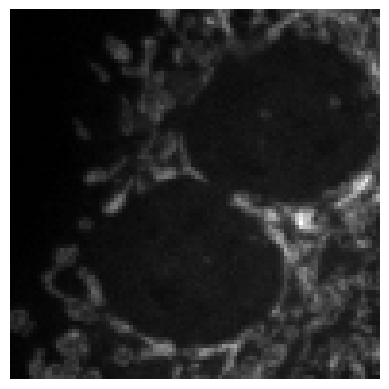

In [ ]:
# Example usage:
output_base_path = '../_data/HDF5_confocal_s96_o08'
file_path = output_base_path + '/noise_gen/test/0500_19.hdf5'
print(file_path)
load_and_display_hdf5_image(file_path, dataset_name='clean', patch_num=1)

In [ ]:
with h5py.File(file_path, 'r') as file:
        image_data = file
        print(list(image_data['config'].attrs.keys()))

['camera', 'exposure-time', 'optical-setup', 'sample-code', 'scene-instance-number', 'scene-number', 'wavelength']


## Datasets

### Base Dataset

In [ ]:
#| export
    
class BaseDataset(Dataset):
    def __init__(self, path=None, add_noise:str=None, crop_size:list=None, aug:list=None, n_repeat:int=1, n_data:int=None, ratio_data:float=None, step:int=None, scale=None) -> None:
        '''
        Base denoising dataset class for various dataset.

        to build custom dataset class, below functions must be implemented in the inherited class. (or see other dataset class already implemented.)
            - self._scan(self) : scan image data & save its paths. (saved to self.img_paths)
            - self._load_data(self, data_idx) : load single paired data from idx as a form of dictionary.

        Args:
            add_noise (str)     : configuration of additive noise to synthesize noisy image. (see _add_noise() for more details.)
            crop_size (list)    : crop size, e.g. [W] or [H, W] and no crop if None
            aug (list)          : list of data augmentations (see _augmentation() for more details.)
            n_repeat (int)      : number of repeat for each data.
            n_data (int)        : number of data to be used. (default: None = all data)
            ratio_data (float)  : ratio of data to be used. (activated when n_data=None, default: None = all data)
        '''
       
        # parse additive noise argument
        self.add_noise_type, self.add_noise_opt, self.add_noise_clamp = self._parse_add_noise(add_noise)

        # set parameters for dataset.
        self.crop_size = crop_size
        self.scale = scale
        self.aug = aug
        self.n_repeat = n_repeat

        self._get_img_paths(path)
        self._apply_step(step)

        # set data amount
        if n_data is not None:       self.n_data = n_data
        elif ratio_data is not None: self.n_data = int(ratio_data * len(self.img_paths))
        else:                        self.n_data = len(self.img_paths)

    def __len__(self):
        return self.n_data * self.n_repeat

    def __getitem__(self, idx):
        '''
        final dictionary shape of data:
        {'clean', 'syn_noisy', 'real_noisy', 'noisy (any of real[first priority] and syn)', etc}
        '''
        # calculate data index
        data_idx = idx % self.n_data

        # load data
        data = self._load_data(data_idx)

        # pre-processing (currently only crop)
        data = self._pre_processing(data)

        # synthesize additive noise 
        if self.add_noise_type is not None:
            if 'clean' in data:
                syn_noisy_img, nlf = self._add_noise(data['clean'], self.add_noise_type, self.add_noise_opt, self.add_noise_clamp)
                data['syn_noisy'] = syn_noisy_img
                data['nlf'] = nlf
            elif 'real_noisy' in data:
                syn_noisy_img, nlf = self._add_noise(data['real_noisy'], self.add_noise_type, self.add_noise_opt, self.add_noise_clamp)
                data['syn_noisy'] = syn_noisy_img
                data['nlf'] = nlf
            else:
                raise RuntimeError('there is no clean or real image to synthesize. (synthetic noise type: %s)'%self.add_noise_type)

        # data augmentation
        if self.aug is not None:
            data = self._augmentation(data, self.aug)

        # add general label 'noisy' to use any of real_noisy or syn_noisy (real first)
        if 'real_noisy' in data or 'syn_noisy' in data:
            data['noisy'] = data['real_noisy'] if 'real_noisy' in data else data['syn_noisy']

        return data

    def _get_img_paths(self, dataset_path):
        if dataset_path is None:
            self.dataset_dir = './dataset'
        else:
            self.dataset_dir = dataset_path
        if not os.path.isdir(self.dataset_dir):
            raise Exception('dataset directory is not exist')
        
        # scan all data and fill in self.img_paths
        self.img_paths = []
        self._scan()
        if len(self.img_paths) > 0:
            if self.img_paths[0].__class__.__name__ in ['int', 'str', 'float']:
                self.img_paths.sort()

    def _apply_step(self, step):
        step_paths = list()
        for idx, path in enumerate(self.img_paths):
            if idx % step == 0:
                step_paths.append(path)
        self.img_paths = step_paths

    def _scan(self):
        raise NotImplementedError
        # TODO fill in self.img_paths (include path from project directory)

    def _load_data(self, data_idx):
        raise NotImplementedError
        # TODO load possible data as dictionary
        # dictionary key list :
        #   'clean' : clean image without noise (gt or anything).
        #   'real_noisy' : real noisy image or already synthesized noisy image.
        #   'instances' : any other information of capturing situation.

    #----------------------------#
    #  Image handling functions  #
    #----------------------------#
    def _load_img(self, img_name, as_gray=False):
        img = cv2.imread(img_name, 1)
        assert img is not None, "failure on loading image - %s"%img_name
        return self._load_img_from_np(img, as_gray, RGBflip=True)

    def _load_img_from_np(self, img, as_gray=False, RGBflip=False):
        # if color
        if len(img.shape) != 2:
            if as_gray:
                # follows definition of sRBG in terms of the CIE 1931 linear luminance.
                # because calculation opencv color conversion and imread grayscale mode is a bit different.
                # https://en.wikipedia.org/wiki/Grayscale
                img = np.average(img, axis=2, weights=[0.0722, 0.7152, 0.2126])
                img = np.expand_dims(img, axis=0)
            else:
                if RGBflip:
                    img = np.flip(img, axis=2)
                img = np.transpose(img, (2,0,1))
        # if gray
        else:                   
            img = np.expand_dims(img, axis=0)
        return torch.from_numpy(np.ascontiguousarray(img).astype(np.float32))

    def _pre_processing(self, data):
        # get a patch from image data
        if self.crop_size != None:
            data = self._get_patch(self.crop_size, data)
        if self.scale != None:
            for x in data:
                data[x] *= self.scale
        return data

    def _get_patch(self, crop_size, data, rnd=True):
        # check all image size is same
        if 'clean' in data and 'real_noisy' in data:
            assert data['clean'].shape[1] == data['clean'].shape[1] and data['real_noisy'].shape[2] == data['real_noisy'].shape[2], \
            'img shape should be same. (%d, %d) != (%d, %d)' % (data['clean'].shape[1], data['clean'].shape[1], data['real_noisy'].shape[2], data['real_noisy'].shape[2])

        # get image shape and select random crop location
        if 'clean' in data:
            max_x = data['clean'].shape[2] - crop_size[0]
            max_y = data['clean'].shape[1] - crop_size[1]
        else:
            max_x = data['real_noisy'].shape[2] - crop_size[0]
            max_y = data['real_noisy'].shape[1] - crop_size[1]

        assert max_x >= 0
        assert max_y >= 0

        if rnd and max_x>0 and max_y>0:
            x = np.random.randint(0, max_x)
            y = np.random.randint(0, max_y)
        else:
            x, y = 0, 0

        # crop
        if 'clean' in data:
            data['clean'] = data['clean'][:, y:y+crop_size[1], x:x+crop_size[0]]
        if 'real_noisy' in data:
            data['real_noisy'] = data['real_noisy'][:, y:y+crop_size[1], x:x+crop_size[0]]
        
        return data

    def normalize_data(self, data, cuda=False):
        # for all image
        for key in data:
            if self._is_image_tensor(data[key]):
                data[key] = self.normalize(data[key], cuda)
        return data

    def inverse_normalize_data(self, data, cuda=False):
        # for all image
        for key in data:
            # is image 
            if self._is_image_tensor(data[key]):
                data[key] = self.inverse_normalize(data[key], cuda)
        return data

    def normalize(self, img, cuda=False):
        if img.shape[0] == 1:
            stds = self.gray_stds
            means = self.gray_means
        elif img.shape[0] == 3:
            stds = self.color_stds
            means = self.color_means
        else:
            raise RuntimeError('undefined image channel length : %d'%img.shape[0])
        
        if cuda:
            means, stds = means.cuda(), stds.cuda() 

        return (img-means) / stds

    def inverse_normalize(self, img, cuda=False):
        if img.shape[0] == 1:
            stds = self.gray_stds
            means = self.gray_means
        elif img.shape[0] == 3:
            stds = self.color_stds
            means = self.color_means
        else:
            raise RuntimeError('undefined image channel length : %d'%img.shape[0])
        
        if cuda:
            means, stds = means.cuda(), stds.cuda() 

        return (img*stds) + means

    def _parse_add_noise(self, add_noise_str:str):
        '''
        noise_type-opt0:opt1:opt2-clamp
        '''
        if add_noise_str == 'bypass':
            return 'bypass', None, None
        elif add_noise_str != None:
            add_noise_type = add_noise_str.split('-')[0]
            add_noise_opt = [float(v) for v in add_noise_str.split('-')[1].split(':')]
            add_noise_clamp = len(add_noise_str.split('-'))>2 and add_noise_str.split('-')[2] == 'clamp'
            return add_noise_type, add_noise_opt, add_noise_clamp
        else:
            return None, None, None

    def _add_noise(self, clean_img:torch.Tensor, add_noise_type:str, opt:list, clamp:bool=False) -> torch.Tensor:
        '''
        add various noise to clean image.
        Args:
            clean_img (Tensor) : clean image to synthesize on
            add_noise_type : below types are available
            opt (list) : args for synthsize noise
            clamp (bool) : optional, clamp noisy image into [0,255]
        Return:
            synthesized_img
        Noise_types
            - bypass : bypass clean image
            - uni : uniform distribution noise from -opt[0] ~ opt[0]
            - gau : gaussian distribution noise with zero-mean & opt[0] variance
            - gau_blind : blind gaussian distribution with zero-mean, variance is uniformly selected from opt[0] ~ opt[1]
            - struc_gau : structured gaussian noise. gaussian filter is applied to above gaussian noise. opt[0] is variance of gaussian, opt[1] is window size and opt[2] is sigma of gaussian filter.
            - het_gau : heteroscedastic gaussian noise with indep weight:opt[0], dep weight:opt[1]
        '''
        nlf = None

        if add_noise_type == 'bypass':
            # bypass clean image
            synthesized_img = clean_img
        elif add_noise_type == 'uni':
            # add uniform noise
            synthesized_img = clean_img + 2*opt[0] * torch.rand(clean_img.shape) - opt[0]
        elif add_noise_type == 'gau':
            # add AWGN
            nlf = opt[0]
            synthesized_img = clean_img + torch.normal(mean=0., std=nlf, size=clean_img.shape)
        elif add_noise_type == 'gau_blind':
            # add blind gaussian noise
            nlf = random.uniform(opt[0], opt[1])
            synthesized_img = clean_img + torch.normal(mean=0., std=nlf, size=clean_img.shape)
        elif add_noise_type == 'struc_gau':
            # add structured gaussian noise (used in the paper "Noiser2Noise": https://arxiv.org/pdf/1910.11908.pdf)
            nlf = opt[0]
            gau_noise = torch.normal(mean=0., std=opt[0], size=clean_img.shape)
            struc_gau = mean_conv2d(gau_noise,  window_size=int(opt[1]), sigma=opt[2], keep_sigma=True)
            synthesized_img = clean_img + struc_gau
        elif add_noise_type == 'het_gau':
            # add heteroscedastic  guassian noise
            het_gau_std = (clean_img * (opt[0]**2) + torch.ones(clean_img.shape) * (opt[1]**2)).sqrt()
            nlf = het_gau_std
            synthesized_img = clean_img + torch.normal(mean=0., std=nlf)
        else:
            raise RuntimeError('undefined additive noise type : %s'%add_noise_type)

        if clamp:
            synthesized_img = torch.clamp(synthesized_img, 0, 255)

        return synthesized_img, nlf

    def _augmentation(self, data:dict, aug:list):
        '''
        Parsing augmentation list and apply it to the data images.
        '''
        # parsign augmentation
        rot, hflip = 0, 0
        for aug_name in aug:
            # aug : random rotation
            if aug_name == 'rot':
                rot = random.randint(0,3)
            # aug : random flip
            elif aug_name == 'hflip':
                hflip = random.randint(0,1)
            else:
                raise RuntimeError('undefined augmentation option : %s'%aug_name)
        
        # for every data(only image), apply rotation and flipping augmentation.
        for key in data:
            if self._is_image_tensor(data[key]):
                # random rotation and flip
                if rot != 0 or hflip != 0:
                    data[key] = rot_hflip_img(data[key], rot, hflip)
            
        return data

    #----------------------------#
    #   Image saving functions   #
    #----------------------------#
    def save_all_image(self, dir, clean=False, syn_noisy=False, real_noisy=False):
        for idx in range(len(self.img_paths)):
            data = self.__getitem__(idx)

            if clean and 'clean' in data:
                cv2.imwrite(os.path.join(dir, '%05d_CL.png'%idx), tensor2np(data['clean']))
            if syn_noisy and 'syn_noisy' in data:
                cv2.imwrite(os.path.join(dir, '%05d_SN.png'%idx), tensor2np(data['syn_noisy']))
            if real_noisy and 'real_noisy' in data:
                cv2.imwrite(os.path.join(dir, '%05d_RN.png'%idx), tensor2np(data['real_noisy']))

            print('image %05d saved!'%idx)

    def prep_save(self, img_idx:int, img_size:int, overlap:int, clean:bool=False, syn_noisy:bool=False, real_noisy:bool=False):
        '''
        cropping am image into mini-size patches for efficient training.
        Args:
            img_idx (int) : index of image
            img_size (int) : size of image
            overlap (int) : overlap between patches
            clean (bool) : save clean image (default: False)
            syn_noisy (bool) : save synthesized noisy image (default: False)
            real_noisy (bool) : save real noisy image (default: False)
        '''
        d_name = '%s_s%d_o%d'%(self.__class__.__name__, img_size, overlap)
        os.makedirs(os.path.join(self.dataset_dir, 'prep', d_name), exist_ok=True)

        assert overlap < img_size
        stride = img_size - overlap

        if clean:
            clean_dir = os.path.join(self.dataset_dir, 'prep', d_name, 'CL')
            os.makedirs(clean_dir, exist_ok=True)
        if syn_noisy: 
            syn_noisy_dir = os.path.join(self.dataset_dir, 'prep', d_name, 'SN')
            os.makedirs(syn_noisy_dir, exist_ok=True)
        if real_noisy:
            real_noisy_dir = os.path.join(self.dataset_dir, 'prep', d_name, 'RN')
            os.makedirs(real_noisy_dir, exist_ok=True)

        data = self.__getitem__(img_idx)

        c,h,w = data['clean'].shape if 'clean' in data else data['real_noisy'].shape
        for h_idx in range((h-img_size)//stride + 1):
            for w_idx in range((w-img_size+1)//stride + 1):
                hl, hr = h_idx*stride, h_idx*stride+img_size
                wl, wr = w_idx*stride, w_idx*stride+img_size
                if clean:      cv2.imwrite(os.path.join(clean_dir,      '%d_%d_%d.png'%(img_idx, h_idx, w_idx)), tensor2np(data['clean'][:,hl:hr,wl:wr])) 
                if syn_noisy:  cv2.imwrite(os.path.join(syn_noisy_dir,  '%d_%d_%d.png'%(img_idx, h_idx, w_idx)), tensor2np(data['syn_noisy'][:,hl:hr,wl:wr])) 
                if real_noisy: cv2.imwrite(os.path.join(real_noisy_dir, '%d_%d_%d.png'%(img_idx, h_idx, w_idx)), tensor2np(data['real_noisy'][:,hl:hr,wl:wr])) 

        print('Cropped image %d / %d'%(img_idx, self.__len__()))
        

    #----------------------------#
    #            etc             #
    #----------------------------#
    def _is_image_tensor(self, x):
        '''
        return input tensor has image shape. (include batched image)
        '''
        if isinstance(x, torch.Tensor):
            if len(x.shape) == 3 or len(x.shape) == 4:
                if x.dtype != torch.bool:
                    return True
        return False




### SIDD (to be changed)

In [ ]:
#| export

@regist_dataset
class SIDD_HDF(BaseDataset):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def _get_img_paths(self, dataset_path):
        assert os.path.exists(dataset_path), f"Invalid dataset path: {dataset_path}"
        self.dataset_path = dataset_path
        self.dataset_dir = dataset_path
        # scan all data and fill in self.img_paths
        self.img_paths = []
        self._scan()

    def iterate_hdf5_objects(self, obj, prefix=""):
        """
        Recursively iterate over all objects in HDF5 file.
        Returns tuple of (name, object).
        """
        for name, obj in obj.items():
            if isinstance(obj, h5py.Dataset):
                yield f"{prefix}/{name}", obj
            elif isinstance(obj, h5py.Group):
                yield from self.iterate_hdf5_objects(obj, f"{prefix}/{name}")

    def _scan(self):
        file_paths = self._get_file_paths(self.dataset_dir, ".hdf5")
        for file_path in tqdm(file_paths):
            with h5py.File(file_path, 'r') as hf:
                assert len(hf['clean']) == len(hf['noisy'])
                for name, obj in self.iterate_hdf5_objects(hf['clean']):
                    h, w,_ = obj.shape
                    self.img_paths.append({'clean': f"clean{name}", 'noisy': f"noisy{name}", 'width': w, 'height': h, 'file_path':file_path}) 
            
    def _load_data(self, data_idx):
        with h5py.File(self.img_paths[data_idx]['file_path'], 'r') as hf:
            clean_img = hf[self.img_paths[data_idx]['clean']][...].astype(np.float32)
            noisy_img = hf[self.img_paths[data_idx]['noisy']][...].astype(np.float32)
        
            if len(clean_img.shape) == 2: clean_img = np.expand_dims(clean_img, axis=0)
            if len(noisy_img.shape) == 2: noisy_img = np.expand_dims(noisy_img, axis=0)
            kwargs = dict()
            for key in hf['config'].attrs.keys():
                kwargs[key] = hf['config'].attrs[key]
        
        return {'clean': clean_img, 'real_noisy': noisy_img, 'kwargs':kwargs}
        
        
    def _get_file_paths(self, path, force_extension=".raw"):
        assert os.path.exists(path), f"{path} dosen't exist."
        assert os.path.isdir(path), f"{path} is not directory."
        
        file_paths = list()
        for r, d, f in os.walk(path):
            for file in f:
                if force_extension is not None:
                    if force_extension in file:
                        file_paths.append(os.path.join(r, file))
                else:
                    file_paths.append(os.path.join(r, file))
        file_paths.sort()
        return file_paths
    

@regist_dataset
class SIDD_val(BaseDataset):
    '''
    SIDD validation dataset class 
    '''
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _scan(self):
        dataset_path = self.dataset_dir
        assert os.path.exists(dataset_path), 'There is no dataset %s'%dataset_path

        clean_mat_file_path = os.path.join(dataset_path, 'ValidationGtBlocksSrgb.mat')
        noisy_mat_file_path = os.path.join(dataset_path, 'ValidationNoisyBlocksSrgb.mat')

        self.clean_patches = np.array(scipy.io.loadmat(clean_mat_file_path, appendmat=False)['ValidationGtBlocksSrgb'])
        self.noisy_patches = np.array(scipy.io.loadmat(noisy_mat_file_path, appendmat=False)['ValidationNoisyBlocksSrgb'])

        # for __len__(), make img_paths have same length
        # number of all possible patch is 1280
        for _ in range(1280):
            self.img_paths.append(None)

    def _load_data(self, data_idx):
        img_id   = data_idx // 32
        patch_id = data_idx  % 32

        clean_img = self.clean_patches[img_id, patch_id, :].astype(float)
        noisy_img = self.noisy_patches[img_id, patch_id, :].astype(float)

        clean_img = self._load_img_from_np(clean_img)
        noisy_img = self._load_img_from_np(noisy_img)

        return {'clean': clean_img, 'real_noisy': noisy_img }

@regist_dataset
class SIDD_benchmark(BaseDataset):
    '''
    SIDD benchmark dataset class
    '''
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _scan(self):
        dataset_path = self.dataset_dir
        assert os.path.exists(dataset_path), 'There is no dataset %s'%dataset_path

        mat_file_path = os.path.join(dataset_path, 'BenchmarkNoisyBlocksSrgb.mat')

        self.noisy_patches = np.array(scipy.io.loadmat(mat_file_path, appendmat=False)['BenchmarkNoisyBlocksSrgb'])

        # for __len__(), make img_paths have same length
        # number of all possible patch is 1280
        for _ in range(1280):
            self.img_paths.append(None)

    def _load_data(self, data_idx):
        img_id   = data_idx // 32
        patch_id = data_idx  % 32

        noisy_img = self.noisy_patches[img_id, patch_id, :].astype(float)

        noisy_img = self._load_img_from_np(noisy_img)

        return {'real_noisy': noisy_img}


In [ ]:
dir_path = '../_data/HDF5_confocal_s96_o08/noise_gen/train/'

data = SIDD_HDF(dir_path, n_data=1, step=1)
data._load_data(0)



  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:19<00:00,  7.86it/s]


{'clean': array([[[3., 3., 3., ..., 6., 6., 6.],
         [3., 3., 3., ..., 6., 6., 6.],
         [3., 3., 3., ..., 6., 6., 7.],
         ...,
         [3., 3., 3., ..., 3., 3., 3.],
         [3., 3., 3., ..., 3., 3., 3.],
         [3., 3., 3., ..., 3., 3., 3.]]], dtype=float32),
 'real_noisy': array([[[ 3.,  3.,  3., ...,  4.,  4.,  5.],
         [ 3.,  3.,  3., ...,  6.,  5.,  7.],
         [ 3.,  3.,  3., ...,  3., 10.,  7.],
         ...,
         [ 6.,  3.,  6., ...,  3.,  3.,  3.],
         [ 3.,  3.,  3., ...,  3.,  3.,  3.],
         [ 3.,  3.,  3., ...,  3.,  3.,  3.]]], dtype=float32),
 'kwargs': {'camera': 2,
  'exposure-time': 60,
  'optical-setup': 1,
  'sample-code': 0,
  'scene-instance-number': 1,
  'scene-number': 1,
  'wavelength': 600}}

In [1]:
#| hide
import nbdev; nbdev.nbdev_export()